### state
distance from avg hsv of orange + blue times number of max
### action
press one key, both, or none (direction of distance determines which keys)
### rewards
score update

$Q[s,a] ← Q[s,a] + α(r+ γ max_{a'} Q[s',a'] - Q[s,a])$

In [35]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from PIL import Image

In [48]:
# params
alpha = 0.95
gamma_const = 0.66
# for exploration
explore_n = 500
explore_rate = 0.004

In [3]:
# save data
Q_vals = np.zeros([100, 3]) # 100 intensities 3 actions
trained_n = 0 # keep track of how many times we've updated Q

In [4]:
def select_action(state):
    return np.argmax(Q_vals[state,:])

def explore(state):
    # with certain probability return random action
    random_test = np.random.random() < (1 / (1 + np.exp(explore_rate * (trained_n - explore_n))))
    if random_test:
        # want to do nothing most often..
        return int(np.floor(np.random.exponential(0.5) % 3))
    else:
        # otherwise just most util
        return select_action(state)

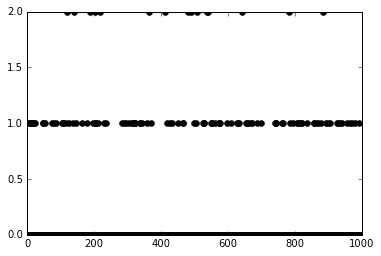

In [5]:
plt.plot([explore(0) for _ in range(1000)], 'ko')

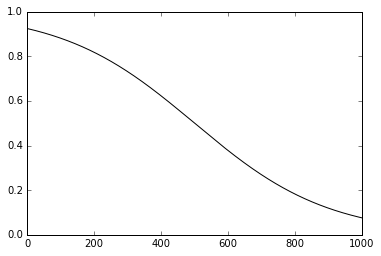

In [26]:
x = np.arange(0, 1000, 0.25)
def f(x):
    return 1 / (1 + np.exp( 0.005 * (x - 500)))

plt.plot(x, f(x), 'k')
plt.show()

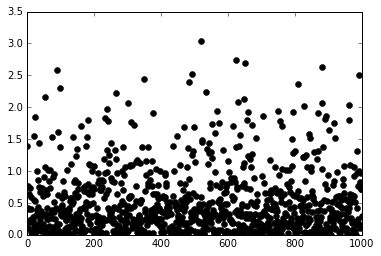

In [182]:
plt.plot(np.random.exponential(0.5, 1000), 'ko')

### train
press any buttons chosen + step
screenshot
### analyze
figure out space (color hist thing)
check if score different
   if yes update q-vals
try new action


In [31]:
last_state_action_pairs = []
last_reward = 0

Q[s,a] for last state / last action combo += discounted reward + gamma * max over actions Q(current state, actions)

In [6]:
# we're gna have a gamma prior on our next state...
from scipy.stats import gamma

In [7]:
# for finding our weighted avg max q-val we precompute some things
pre_comp_gamma = np.zeros([100, 100])
pre_comp_gamma_sum = np.zeros(100)
def precompute_gamma_weights():
    start_x = np.arange(0.1, 10.1, 0.1)
    for i in range(100):
        dist = gamma((i + 1) / 10)
        pre_comp_gamma[i] = dist.pdf(start_x)
    pre_comp_gamma_sum = np.sum(pre_comp_gamma, axis=1)

In [74]:
def find_weighted_max_q_val(last_state):
    # weighted mean
    wm_t = np.sum(np.multiply(Q_vals.transpose(), pre_comp_gamma[last_state]), axis=1)
    wm = wm_t / (pre_comp_gamma_sum[last_state] + 1e-8 )
    return np.max(wm)

In [78]:
# accessing q Q_vals[(50,2)] (state, action)
# reward factor constant (must be > 1)
r_f = 1.25

def update_q(new_reward):
    global last_reward, Q_vals
    # normalize reward
    n_reward = new_reward * (np.sign(new_reward - last_reward) + r_f) / (1 + r_f)
    # update last reward..
    last_reward = new_reward
    for t, sap in enumerate(last_state_action_pairs):
        max_a_q = find_weighted_max_q_val(sap[0])
        # i had (gamma ** (t + 1)) in here.. but i dont think extra discounting is necessary?
        # we should apply what we've learned to everything equally after getting feedback.
        Q_vals[sap] += alpha * (n_reward + (gamma_const * max_a_q) - Q_vals[sap])

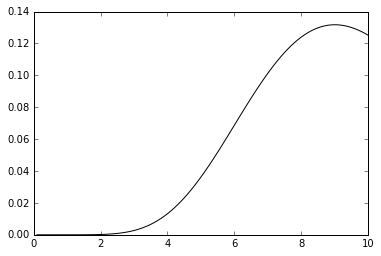

In [68]:
plt.plot(np.arange(0.1, 10.1, 0.1), pre_comp_gamma[99], ls='-', color='black')
plt.show()

i realized i want to shift the window a little forward in order to have a non-symmetric mapping of state-space to (expected) reward
otherwise things that we've already missed pressing will be in same state as things we can still press in time!

In [ ]:
# let's try to do that with the nicely written funs...

In [1]:
import os
os.chdir('../') # RUN ONCE ONLY

In [125]:
from tAIko.brains import imaging

In [115]:
imh = imaging.ImageHelper()
extract_path = './resources/taikotemp/recordings/extracted'

In [111]:
def show_screen(scrot_as_array):
    plt.figure(figsize=(5,10))
    plt.axis('off')
    plt.imshow(scrot_as_array, interpolation ='none')
    plt.show()

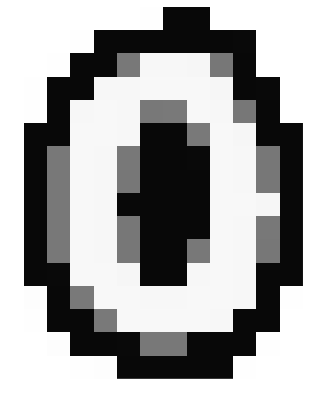

In [114]:
show_screen(imh.clean_array_mask(0))
# nice!

In [126]:
a_frame = imh.clean_pic(extract_path + '/out-75.png')

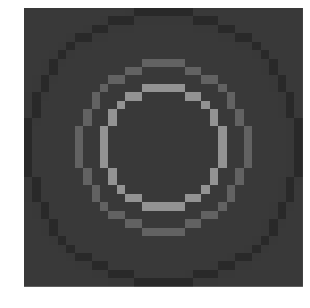

In [128]:
show_screen(a_frame[75:108, 13:46, :])

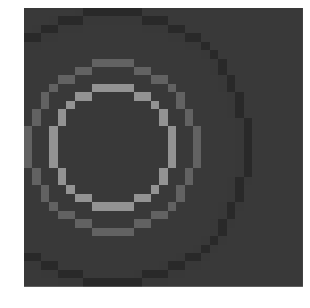

In [134]:
o = 6
snippy = a_frame[75:108, 13+o:46+o, :]
show_screen(snippy)

now it is time to begin!

In [ ]:
# TODO
# ds control
# - need to detect lvl finish in order to restart & select another lvl
# - frameskip of 2
# training..
# - start lvl
# - start taking screenshots
# - every frame(skip) pick action
# - analyze score
#   - update q's
# - once done training, dump q_vals
# testing..
# - same as training except don't analyze score

# what this will look like
# first add lvl-detect finish (screen becomes all black..)
# instantiate control, brains, imagehelp
# and then just throw everything else in separate step funs (for training/testing)
# add some ffmpeg magic to make vid

In [135]:
# let's detect lvl end
import subprocess

In [136]:
video_path = './resources/taikotemp/recordings/test_1.avi'
extract_path = './resources/taikotemp/recordings/extracted_end'
file_info = ''

if not os.path.exists(extract_path):
    os.mkdir(extract_path)

fps_cmd = 'ffmpeg -hide_banner -i {}'.format(video_path)

try:
    subprocess.check_output(fps_cmd, stderr=subprocess.STDOUT, shell=True)
except subprocess.CalledProcessError as e:
    file_info = e.output
file_info = file_info.decode('utf-8')
file_info = file_info.split('\n')

fps = None

for line in file_info:
    if 'fps' in line:
        split_line = line.split(" ")
        fps = split_line[split_line.index('fps,')-1]

if fps is not None:
    extract_command = "ffmpeg -i {} -r {} {}/out-%d.png".format(video_path, fps, extract_path)
    subprocess.call(extract_command, shell=True)

In [137]:
e_frame_1 = imh.clean_pic(extract_path + '/out-271.png')
e_frame_2 = imh.clean_pic(extract_path + '/out-272.png')

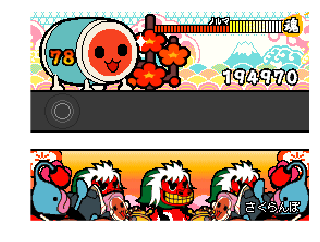

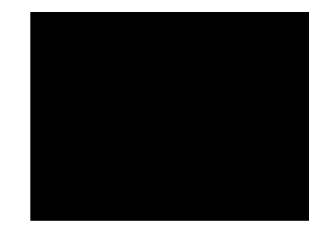

In [146]:
show_screen(e_frame_1[:192, :, :])
show_screen(e_frame_2[:192, :, :])
# k, top half becomes all black

In [155]:
def check_if_over(c_frame):
    top_half = c_frame[:192, :, :]
    return np.sum(np.mean(np.mean(top_half, axis=1), axis=0) - [0, 0, 0]) < 10

In [157]:
check_if_over(e_frame_1), check_if_over(e_frame_2)

(False, True)

In [ ]:
# let's train!

In [2]:
from tAIko.control import ds
trainer = ds.Training()

In [23]:
from tAIko.brains import imaging
imh = imaging.ImageHelper()

In [26]:
from tAIko.brains import analysis
ds_s = analysis.DS_Scorer(imh)
ds_a = analysis.DS_Color_Picker(imh)

In [87]:
trainer.choose_new_track() # this is still buggy and only works every other time :(

In [52]:
def training_step():
    global last_state_action_pairs, trained_n
    # frame skip
    trainer.advance_frame()
    
    # get pic
    new_f_fname = trainer.find_last_frame()
    new_frame = imh.clean_pic(new_f_fname)
    
    # if lvl ended we start over
    if ds_a.check_lvl_over(new_frame):
        trainer.choose_new_track()
        ds_s.restart()
        return
    
    # check if score updated
    new_score, score_diff = ds_s.get_score(new_frame)
    
    if score_diff > 0:
        print('updating qz score_diff was', score_diff)
        update_q(score_diff)
        trained_n += 1
        last_state_action_pairs = []

    # find current state
    color_choice, s = ds_a.pick_color(new_frame)
    cur_state = int(np.floor(100 * s))
        
    # pick a new action?
    num_but = explore(cur_state)
    print(color_choice, cur_state, 'pressing', num_but, 'buttons')
    trainer.advance_frame([color_choice, num_but])
    last_state_action_pairs += [(cur_state, num_but)]
    
    
    

In [86]:
for _ in range(100):
    try:
        training_step()
    except Exception as e:
        print('messed up\n', e)

None 0 pressing 0 buttons
None 0 pressing 0 buttons
None 0 pressing 0 buttons
None 0 pressing 1 buttons
None 0 pressing 0 buttons
None 0 pressing 0 buttons
None 0 pressing 0 buttons
None 0 pressing 0 buttons
None 0 pressing 1 buttons
None 0 pressing 0 buttons
None 0 pressing 0 buttons
o 3 pressing 1 buttons
o 11 pressing 0 buttons
o 70 pressing 0 buttons
o 64 pressing 0 buttons
o 59 pressing 0 buttons
o 56 pressing 0 buttons
b 43 pressing 0 buttons
b 42 pressing 0 buttons
b 36 pressing 0 buttons
b 31 pressing 0 buttons
b 20 pressing 0 buttons
o 13 pressing 0 buttons
o 6 pressing 0 buttons
o 2 pressing 0 buttons
o 8 pressing 0 buttons
o 13 pressing 0 buttons
b 23 pressing 0 buttons
b 31 pressing 0 buttons
b 37 pressing 0 buttons
b 43 pressing 1 buttons
b 43 pressing 2 buttons
updating qz score_diff was 530
o 73 pressing 0 buttons
b 82 pressing 0 buttons
o 90 pressing 0 buttons
o 90 pressing 0 buttons
o 90 pressing 0 buttons
o 33 pressing 0 buttons
o 27 pressing 0 buttons
o 11 pressing 0

In [53]:
Q_vals
# nice!!
# nan stands for nice and neat : )

array([[ nan,  nan,  nan],
       [ nan,   0.,   0.],
       [ nan,   0.,   0.],
       [ nan,   0.,   0.],
       [  0.,  nan,   0.],
       [  0.,   0.,   0.],
       [ nan,   0.,   0.],
       [  0.,  nan,   0.],
       [  0.,   0.,   0.],
       [  0.,   0.,   0.],
       [ nan,   0.,   0.],
       [ nan,   0.,   0.],
       [ nan,   0.,   0.],
       [  0.,   0.,   0.],
       [  0.,   0.,   0.],
       [ nan,  nan,   0.],
       [ nan,   0.,   0.],
       [  0.,   0.,   0.],
       [ nan,   0.,   0.],
       [  0.,   0.,   0.],
       [  0.,   0.,   0.],
       [  0.,   0.,   0.],
       [  0.,   0.,   0.],
       [  0.,   0.,   0.],
       [  0.,   0.,   0.],
       [  0.,   0.,   0.],
       [  0.,   0.,   0.],
       [  0.,   0.,  nan],
       [  0.,   0.,   0.],
       [  0.,   0.,   0.],
       [  0.,   0.,   0.],
       [  0.,   0.,   0.],
       [  0.,   0.,   0.],
       [  0.,   0.,   0.],
       [ nan,   0.,   0.],
       [  0.,   0.,   0.],
       [  0.,   0.,   0.],
 

In [77]:
new_reward = 260
n_reward = new_reward * (np.sign(new_reward - last_reward) + r_f) / (1 + r_f)
# # update last reward..
# last_reward = new_reward
for t, sap in enumerate(last_state_action_pairs[:1]):
    print(sap)
    max_a_q = find_weighted_max_q_val(sap[0])
    print(max_a_q)
#     # i had (gamma ** (t + 1)) in here.. but i dont think extra discounting is necessary?
#     # we should apply what we've learned to everything equally after getting feedback.
    print(alpha * (n_reward + (gamma_const * max_a_q) - Q_vals[sap]))

(0, 1)
0.0
137.222222222


In [88]:
Q_vals

array([[ 530.        ,  529.99987951,  144.15559155],
       [ 138.66681724,  137.22222222,    0.        ],
       [ 528.74722231,    0.        ,    0.        ],
       [ 510.43405555,  504.87222222,    0.        ],
       [  30.07541667,  144.08333333,    0.        ],
       [ 504.87222222,   27.44444444,    0.        ],
       [ 529.02170052,   27.44444444,    0.        ],
       [  29.15972222,  137.22222222,    0.        ],
       [ 503.5       ,    0.        ,    0.        ],
       [   0.        ,  137.22222222,    0.        ],
       [ 139.87124774,    0.        ,    0.        ],
       [  52.69170277,    0.        ,    0.        ],
       [ 528.74725608,    0.        ,    0.        ],
       [ 529.02170277,   28.81666667,    0.        ],
       [  52.61944444,    0.        ,    0.        ],
       [ 504.9445949 ,  137.22222222,   27.44444444],
       [ 504.94444444,  145.34208333,    0.        ],
       [ 529.93375   ,    0.        ,    0.        ],
       [  34.30555556,    0.

In [ ]:
# nice, everything works.. maybe want to add messup check in order to have negative scores?

In [71]:
last_state = (0, 1)
# weighted mean
wm_t = np.sum(np.multiply(Q_vals.transpose(), pre_comp_gamma[last_state]), axis=1)
wm = wm_t / (pre_comp_gamma_sum[last_state[0]] + 1e-8 )


0.0


In [70]:
pre_comp_gamma_sum[last_state[0]] + 1e-8

1e-08

In [66]:
np.multiply(Q_vals.transpose(), pre_comp_gamma[last_state])

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

In [65]:
Q_vals = np.zeros([100, 3]) # 100 intensities 3 actions

In [89]:
# k, everything works but it's mad slow
trained_n

7

In [14]:
# fixing lvl select..

trainer.kp.unpause()


In [32]:
trainer.kp.send_key('pause')

In [28]:
trainer.back_to_menu()

In [27]:
for _ in range(5):
    trainer.kp.send_key('left')

In [26]:
trainer.kp.send_key('a')


In [33]:
# loading / saving np array from disk
save_file = './resources/training_savedata/q_vals.npy'
if os.path.exists(save_file):
    test_arr = np.load(save_file)

In [38]:
test_arr = np.random.rand(10,5)